**Step 0 - install and import dependencies**

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [ ]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [ ]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [ ]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [ ]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [ ]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

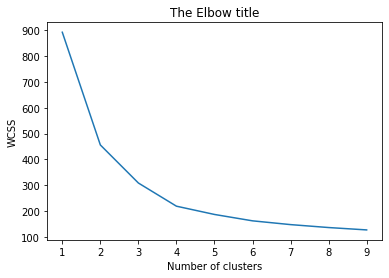

In [ ]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [ ]:
df_kmeans

,KMeans ID,texts
0,0,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
3,3,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...


In [ ]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [ ]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [ ]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [ ]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [ ]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [ ]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน']
screening_words = stopwords + removed_words

new_words = {"สตารบัก"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เด, ...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ทาน, 11), (ชอบ, ..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (กก, 7), (กิน, 7), (อร่อย, 6..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (ทาน, 6), (..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 10), (อร่อย, 9), (ทาน, 7), (ผม, 7), (รี..."


In [ ]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ทาน', 11), ('ชอบ', 8), ('คาเฟ่', 6), ('กิน', 6), ('แวะ', 6), ('น่ารัก', 5), ('น', 5), ('นั่ง', 5)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 11), ('กก', 7), ('กิน', 7), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ทาน', 5), ('ราคา', 5), ('สวัสดี', 4), ('เพื่อน', 4)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('ทาน', 6), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอยู่', 3), ('รีวิว', 3), ('ลอง', 3), ('เดิน', 3)]

Cluster ID : 3

Most common words include : [('กิน', 10), ('อร่อย', 9), ('ทาน', 7), ('ผม', 7), ('รีวิว', 7), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('กก', 5), ('อาหาร', 4)]



**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [ ]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 508), ('ทาน', 416), ('รสชาติ', 407), ('ดี', 347), ('กิน', 339), ('กาแฟ', 311), ('เมนู', 309), ('สั่ง', 301), ('อาหาร', 285), ('ราคา', 273)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3)]

Cluster ID : 2

Most common words include : [('ดิชั้น', 4), ('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ("['", 1), ('ดิ', 1), ('ช้ัน', 1), ('ทบ', 1), ('น', 1)]

Cluster ID : 3

Most common words include : [('นม', 3), ('แน่น', 2), ('tamp', 2), ('เท', 2), ('แก้', 2), ("['", 1), ('เรื่อง', 1), ('ขนม', 1), ('สันทัด', 1), ('ดังนั้น', 1)]



**Step 4 - result discussion**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
document = df_kmeans['texts_tokenized']
document

0    [คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เด, ...
1    [กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...
2    [ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...
3    [มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...
Name: texts_tokenized, dtype: object

In [ ]:
tokens_list = [tokenize_to_list(txt) for txt in document]

list

In [ ]:
cluster_list = [','.join(tkn) for tkn in tokens_list]
cvec = CountVectorizer(analyzer=lambda x:x.split(','))
c_feat = cvec.fit_transform(cluster_list)

In [ ]:
cvec.vocabulary_

{'': 0,
 ' ': 1,
 '"\'"': 2,
 "'": 3,
 "'!!'": 4,
 "'!'": 5,
 "'('": 6,
 "'(/คน)'": 7,
 "'(คน'": 8,
 "'(คืด้วย'": 9,
 "'/'": 10,
 "':'": 11,
 "'>>'": 12,
 "']": 13,
 "']'": 14,
 "'~'": 15,
 "'ก'": 16,
 "'กก'": 17,
 "'กค'": 18,
 "'กล'": 19,
 "'กั'": 20,
 "'กัตอน'": 21,
 "'กัส้ม'": 22,
 "'ข'": 23,
 "'ข้ผม'": 24,
 "'ค'": 25,
 "'คน'": 26,
 "'ครัค'": 27,
 "'คอ'": 28,
 "'ค่'": 29,
 "'งง'": 30,
 "'งๆ'": 31,
 "'จ'": 32,
 "'จรัญ'": 33,
 "'จั'": 34,
 "'จัระ'": 35,
 "'ช'": 36,
 "'ชม'": 37,
 "'ชล'": 38,
 "'ชืร้าน'": 39,
 "'ช้อปไ'": 40,
 "'ช้ัน'": 41,
 "'ช๊อป'": 42,
 "'ซขอ'": 43,
 "'ซด'": 44,
 "'ซั่ว'": 45,
 "'ด'": 46,
 "'ดัอุดร'": 47,
 "'ดื่หา'": 48,
 "'ด้ว'": 49,
 "'ตก'": 50,
 "'ตัมา'": 51,
 "'ตัสา'": 52,
 "'ต่'": 53,
 "'ต่า'": 54,
 "'ต์'": 55,
 "'ถึ'": 56,
 "'ท'": 57,
 "'ทด'": 58,
 "'ทบ'": 59,
 "'ทึ่'": 60,
 "'ท๊อป'": 61,
 "'ธร'": 62,
 "'น'": 63,
 "'นม'": 64,
 "'นว'": 65,
 "'นอ'": 66,
 "'นั่'": 67,
 "'นี'": 68,
 "'น้'": 69,
 "'น้อผม'": 70,
 "'น์'": 71,
 "'บ'": 72,
 "'บร'": 73,
 "'บอ'": 74,
 "'บั

In [ ]:
#Create CountVectorizer
print(cluster_list)
count_vectorizer = CountVectorizer()

sparse_matrix = count_vectorizer.fit_transform(cluster_list)  #fit_transform=>Learn the vocabulary dictionary and return document-term matrix.
print(sparse_matrix)

doc_term_matrix = sparse_matrix.todense() #Convert tuple words into matrix
print(doc_term_matrix)

['[\'คน\',, ,\',ชอบ,\',, ,\',ทาน,\',, ,\',Macchiato,\',, ,\',เป็นประจำ,\',, ,\',นึง,\',, ,\',เด,\',, ,\',ArtofCoffeeKasetsart,\',, ,\',ร้านกาแฟ,\',, ,\',รสชาติ,\',, ,\',เย,\',, ,\'ี่\',, ,\',Starbucksn,\',, ,\':\',, ,\',Starbucks,\',, ,\'นี\',, ,\'เบอ\',, ,\',เก,\',, ,\'อ\',, ,\',รี่,\',, ,\',ล้างรถ,\',, ,\',ชื่อว่า,\',, ,\',โลตัส,\',, ,\',พัฒนาการ,\',, ,\',ชี,\',, ,\'ท\',, ,\',เค้ก,\',, ,\',หม่ำ,\',, ,\',นึง,\',, ,\'ค่\',, ,\',ร้านกาแฟ,\',, ,\',เบเกอรี่,\',, ,\',โฮมเมด,\',, ,\',อร่อย,\',, ,\'ส\',, ,\',ไส,\',, ,\'ต์\',, ,\',-cake,\',, ,\',ร้านกาแฟ,\',, ,\',แอนด์,\',, ,\',เบเกอรี่,\',, ,\',ร้านกาแฟ,\',, ,\',ทาน,\',, ,\',บุฟเฟต์,\',, ,\',เสาร์,\',, ,\',อา,\',, ,\',ทิต,\',, ,\',ทาน,\',, ,\',ทองม้วน,\',, ,\'สด\',, ,\',ทาน,\',, ,\',แบ,\',, ,\'บอ\',, ,\'ร่\',, ,\',ร้านกาแฟ,\',, ,\',เข้าไป,\',, ,\',บรรยาย,\',, ,\',กา,\',, ,\'ศ\',, ,\'แร้าน\',, ,\',อาหาร,\',, ,\',เครื่องดื่ม,\',, ,\',ราคา,\',, ,\',เป็นกันเอง,\',, ,\'ๆาน\',, ,\',พาย,\',, ,\'จ\',, ,\',ริ,\',, ,\',คาเฟ่,\',, ,\',เบเกอรี่,\',, ,\'

In [ ]:
print(cluster_list)
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(cluster_list)  
doc_term_matrix = sparse_matrix.todense() 

df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=['cluster0', 'cluster1','cluster2',"cluster3"])
df

['[\'คน\',, ,\',ชอบ,\',, ,\',ทาน,\',, ,\',Macchiato,\',, ,\',เป็นประจำ,\',, ,\',นึง,\',, ,\',เด,\',, ,\',ArtofCoffeeKasetsart,\',, ,\',ร้านกาแฟ,\',, ,\',รสชาติ,\',, ,\',เย,\',, ,\'ี่\',, ,\',Starbucksn,\',, ,\':\',, ,\',Starbucks,\',, ,\'นี\',, ,\'เบอ\',, ,\',เก,\',, ,\'อ\',, ,\',รี่,\',, ,\',ล้างรถ,\',, ,\',ชื่อว่า,\',, ,\',โลตัส,\',, ,\',พัฒนาการ,\',, ,\',ชี,\',, ,\'ท\',, ,\',เค้ก,\',, ,\',หม่ำ,\',, ,\',นึง,\',, ,\'ค่\',, ,\',ร้านกาแฟ,\',, ,\',เบเกอรี่,\',, ,\',โฮมเมด,\',, ,\',อร่อย,\',, ,\'ส\',, ,\',ไส,\',, ,\'ต์\',, ,\',-cake,\',, ,\',ร้านกาแฟ,\',, ,\',แอนด์,\',, ,\',เบเกอรี่,\',, ,\',ร้านกาแฟ,\',, ,\',ทาน,\',, ,\',บุฟเฟต์,\',, ,\',เสาร์,\',, ,\',อา,\',, ,\',ทิต,\',, ,\',ทาน,\',, ,\',ทองม้วน,\',, ,\'สด\',, ,\',ทาน,\',, ,\',แบ,\',, ,\'บอ\',, ,\'ร่\',, ,\',ร้านกาแฟ,\',, ,\',เข้าไป,\',, ,\',บรรยาย,\',, ,\',กา,\',, ,\'ศ\',, ,\'แร้าน\',, ,\',อาหาร,\',, ,\',เครื่องดื่ม,\',, ,\',ราคา,\',, ,\',เป็นกันเอง,\',, ,\'ๆาน\',, ,\',พาย,\',, ,\'จ\',, ,\',ริ,\',, ,\',คาเฟ่,\',, ,\',เบเกอรี่,\',, ,\'

,alittlesweet,aprilstore,artofcoffee,artofcoffeekasetsart,basic,big,bigc,blackcanyon,brunchset,bts,bypupe,cake,catcafe,coffeeway,cp,dakasi,dessennnnn,fukumatcha,happyman,homemade,icecaramelmacchiato,location,lordofcoffee,love,macchiato,mangotreesilom,mochacho,nearrivergoldentriangle,nn,no,nthemallbangkapifl,ochaya,oishibuffet,openrice,orientalnp,pureplace,review,ricemango,sf,sipnsurf,...,โรงพยาบาล,โรงหน,โรงแรม,โลต,โอ,โอกาส,โฮมเมด,โฮมโปร,ใจ,ใจจร,ในเคร,ให,ใหม,ไก,ไกล,ไข,ไช,ได,ไต,ไทย,ไปมา,ไปรษณ,ไปหา,ไปเท,ไพ,ไฟ,ไม,ไร,ไส,ไหนๆ,ไหม,ไอ,ไอต,ไอศคร,ไออ,ๆคน,ๆถ,ๆอร,ๆาน,ๆๆ
cluster0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,1,...,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
cluster1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,1,0,1,1,1,0,0,0,0,1,1,0,0,1,0,2,0,0,0,4,0,1,0,0,1,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0
cluster2,1,2,0,0,1,1,1,0,0,1,0,0,0,0,0,2,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,2,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,15,0,3,3,0,1,0,0,0,0,0,0,0,0,0,2,1,0,1,1,0,1,0,0,0
cluster3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,5,0,0,1,0,0,1,2,0,0,1,1,0,0,1,2,0,0,1,0,0,1,0,0,1,0,0,2,0,0,0,0,1,0,2


In [ ]:
#Create TfidfVectorizer
vectorizer = TfidfVectorizer()
sparse_matrix = vectorizer.fit_transform(cluster_list)
doc_term_matrix = sparse_matrix.todense()
df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=['cluster0', 'cluster1','cluster2',"cluster3"])
df

,alittlesweet,aprilstore,artofcoffee,artofcoffeekasetsart,basic,big,bigc,blackcanyon,brunchset,bts,bypupe,cake,catcafe,coffeeway,cp,dakasi,dessennnnn,fukumatcha,happyman,homemade,icecaramelmacchiato,location,lordofcoffee,love,macchiato,mangotreesilom,mochacho,nearrivergoldentriangle,nn,no,nthemallbangkapifl,ochaya,oishibuffet,openrice,orientalnp,pureplace,review,ricemango,sf,sipnsurf,...,โรงพยาบาล,โรงหน,โรงแรม,โลต,โอ,โอกาส,โฮมเมด,โฮมโปร,ใจ,ใจจร,ในเคร,ให,ใหม,ไก,ไกล,ไข,ไช,ได,ไต,ไทย,ไปมา,ไปรษณ,ไปหา,ไปเท,ไพ,ไฟ,ไม,ไร,ไส,ไหนๆ,ไหม,ไอ,ไอต,ไอศคร,ไออ,ๆคน,ๆถ,ๆอร,ๆาน,ๆๆ
cluster0,0.00000,0.00000,0.031315,0.031315,0.00000,0.00000,0.00000,0.000000,0.000000,0.024689,0.031315,0.031315,0.031315,0.000000,0.031315,0.00000,0.00000,0.00000,0.031315,0.031315,0.000000,0.00000,0.031315,0.000000,0.031315,0.000000,0.031315,0.031315,0.000000,0.031315,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.031315,0.000000,0.00000,0.031315,...,0.024689,0.00000,0.000000,0.024689,0.000000,0.024689,0.031315,0.00000,0.024689,0.000000,0.024689,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.024689,0.00000,0.019988,0.019988,0.000000,0.062631,0.000000,0.000000,0.000000,0.000000,0.000000,0.031315,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.031315,0.00000,0.000000,0.031315,0.000000
cluster1,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.041965,0.041965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.041965,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.041965,0.00000,0.00000,0.041965,0.000000,0.000000,0.00000,0.000000,...,0.033086,0.00000,0.041965,0.033086,0.041965,0.000000,0.000000,0.00000,0.000000,0.041965,0.033086,0.000000,0.000000,0.041965,0.00000,0.053572,0.000000,0.000000,0.00000,0.107144,0.000000,0.041965,0.000000,0.000000,0.041965,0.041965,0.000000,0.125896,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
cluster2,0.03859,0.07718,0.000000,0.000000,0.03859,0.03859,0.03859,0.000000,0.000000,0.030425,0.000000,0.000000,0.000000,0.000000,0.000000,0.07718,0.03859,0.03859,0.000000,0.000000,0.000000,0.03859,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.03859,0.07718,0.000000,0.03859,0.03859,0.000000,0.000000,0.000000,0.03859,0.000000,...,0.000000,0.03859,0.000000,0.000000,0.000000,0.000000,0.000000,0.03859,0.000000,0.000000,0.000000,0.030425,0.000000,0.000000,0.03859,0.369474,0.000000,0.091275,0.11577,0.000000,0.024632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.07718,0.03859,0.000000,0.03859,0.03859,0.000000,0.03859,0.000000,0.000000,0.000000
cluster3,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040805,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.040805,0.00000,0.000000,0.040805,0.000000,0.000000,0.000000,0.000000,0.040805,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.040805,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.160857,0.000000,0.00000,0.032171,0.000000,0.000000,0.032171,0.081611,0.000000,0.00000,0.026046,0.040805,0.000000,0.00000,0.026046,0.052091,0.000000,0.000000,0.040805,0.000000,0.000000,0.040805,0.000000,0.000000,0.040805,0.00000,0.00000,0.081611,0.00000,0.00000,0.000000,0.00000,0.040805,0.000000,0.081611


In [ ]:
df = np.transpose(df)
df

,cluster0,cluster1,cluster2,cluster3
alittlesweet,0.000000,0.0,0.03859,0.000000
aprilstore,0.000000,0.0,0.07718,0.000000
artofcoffee,0.031315,0.0,0.00000,0.000000
artofcoffeekasetsart,0.031315,0.0,0.00000,0.000000
basic,0.000000,0.0,0.03859,0.000000
...,...,...,...,...
ๆคน,0.031315,0.0,0.00000,0.000000
ๆถ,0.000000,0.0,0.03859,0.000000
ๆอร,0.000000,0.0,0.00000,0.040805
ๆาน,0.031315,0.0,0.00000,0.000000


In [ ]:
print('cluster0')
print(df.sort_values('cluster0', ascending=False).head(10))
print('cluster1')
print(df.sort_values('cluster1', ascending=False).head(10))
print('cluster2')
print(df.sort_values('cluster2', ascending=False).head(10))
print('cluster3')
print(df.sort_values('cluster3', ascending=False).head(10))

cluster0
        cluster0  cluster1  cluster2  cluster3
านกาแฟ  0.439740  0.000000  0.024632  0.130228
กาแฟ    0.310492  0.065698  0.020138  0.106470
คาเฟ    0.187892  0.000000  0.000000  0.000000
ทาน     0.179758  0.109496  0.120828  0.149058
เด      0.163417  0.043799  0.120828  0.191646
าน      0.163417  0.240892  0.060414  0.276822
ชอบ     0.159906  0.000000  0.024632  0.104182
อน      0.130733  0.131396  0.020138  0.106470
ซอน     0.125262  0.000000  0.000000  0.000000
แนว     0.125262  0.000000  0.000000  0.000000
cluster1
         cluster0  cluster1  cluster2  cluster3
านอาหาร  0.019988  0.294645  0.000000  0.104182
าน       0.163417  0.240892  0.060414  0.276822
กก       0.000000  0.231602  0.000000  0.160857
ซอย      0.024689  0.198516  0.000000  0.000000
อย       0.081708  0.197093  0.020138  0.319410
แซ       0.000000  0.167861  0.000000  0.000000
ราคา     0.049379  0.165430  0.000000  0.000000
สด       0.099941  0.133930  0.000000  0.052091
เพ       0.019988  0.133930  0.00

SUMMARY

cluster0 : ร้านกาแฟ

cluster1 : ร้านอาหาร

cluster2 : ชานม

cluster3 : กาแฟอร่อย